Predictive Analysis – Overview — end-to-end workflow for data preparation, analysis, and modeling.

Data Ingestion: Reads input dataset(s) into pandas DataFrames for downstream processing.

Libraries: Uses pandas, numpy, matplotlib, seaborn, scipy, sklearn (with plotting via matplotlib/seaborn).

Cleaning: Handles missing values, fixes invalid zeros/negatives, standardizes units/rounding, drops duplicates, and coerces dtypes.

Time Features: Parses ISO timestamps, and supports deriving calendar/time-of-day features for temporal analysis.

Feature Engineering: Creates domain features (e.g., high-glucose flags, rolling stats), plus optional encoding/scaling for models.

EDA & Visuals: Produces distributions and trend plots, correlation views, and a Pareto chart of high-glucose events.

Modeling & Evaluation: Includes classic ML (e.g., Decision Trees, Random Forest, Logistic Regression, SVM) with train/validation and metrics.

Pareto Focus: Ranks patients by # of highs, plots cumulative contribution, and isolates the “vital few” (~20%) driving most events.

Outputs: Exports cleaned data/figures and highlights the priority patient cohort for targeted interventions & dashboards.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load the Dataset

In [3]:
diabts_df = pd.read_excel("Team7_DataDynamos_cleaned_data.xlsx", engine="openpyxl")

In [4]:
diabts_df.columns.tolist()

['Patient ID',
 'time',
 'glucose',
 'calories',
 'heart_rate',
 'steps',
 'basal_rate',
 'bolus_volume_delivered',
 'carb_input',
 'Age',
 'Gender',
 'Race',
 'Average Sleep Duration (hrs)',
 'Sleep Quality (1-10)',
 '% with Sleep Disturbances',
 'hour_of_day',
 'day_of_week',
 'high_glucose']

In [5]:
from scipy.stats import mannwhitneyu
import pandas as pd

results = {}

# Select only numeric columns
numeric_cols = diabts_df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    group_yes = diabts_df[diabts_df['high_glucose'] == 1][col].dropna()
    group_no = diabts_df[diabts_df['high_glucose'] == 0][col].dropna()

    if len(group_yes) > 0 and len(group_no) > 0:
        stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')
        results[col] = {
            'U-statistic': round(stat, 3),
            'p-value': p,
            'Chance of randomness (%)': round(p*100, 5)
        }
    else:
        results[col] = {
            'U-statistic': None,
            'p-value': None,
            'Chance of randomness (%)': None
        }

pd.DataFrame(results).T.sort_values('p-value')


,U-statistic,p-value,Chance of randomness (%)
glucose,1.620057e+10,0.000000e+00,0.0
heart_rate,9.222094e+09,0.000000e+00,0.0
steps,8.864958e+09,0.000000e+00,0.0
Age,6.665880e+09,0.000000e+00,0.0
Sleep Quality (1-10),6.889905e+09,0.000000e+00,0.0
high_glucose,1.620057e+10,0.000000e+00,0.0
Average Sleep Duration (hrs),9.938362e+09,0.000000e+00,0.0
hour_of_day,8.549199e+09,4.090346e-107,0.0
% with Sleep Disturbances,7.782908e+09,1.795059e-66,0.0
bolus_volume_delivered,8.163454e+09,2.987729e-62,0.0


Mann-Whitney U test results for the numeric features in your dataset:
Highly significant differences: Most features have p-values ≈ 0, indicating the high_glucose vs low_glucose groups differ strongly; the chance of randomness is effectively 0%.

Top predictive features: glucose, heart_rate, steps, Age, Sleep Quality (1-10), and Average Sleep Duration (hrs) show the highest U-statistics, making them the strongest indicators for high glucose events.

Moderate contributors: hour_of_day, % with Sleep Disturbances, bolus_volume_delivered, calories, carb_input, basal_rate, and day_of_week also show significant differences but with smaller effects.
Takeaway: Focus on the top features for modeling or feature selection (glucose, heart_rate, steps, Age, Sleep Quality, Average Sleep Duration) since they provide the strongest signal for predicting high glucose events.

### Preprocessing and Training:
This code cleans, preprocesses, and splits the dataset so you can plug it into machine learning models (like Logistic Regression, Random Forest, SVM, etc.) to predict high glucose levels based on lifestyle, demographic, and medical factors.
Prepare diabetes dataset (diabts_df) so that it’s ready for training and testing machine learning models.
It selects relevant independent variables (features) like Age, Gender, steps, calories, heart rate, sleep quality, etc., and sets high_glucose as the target variable to be predicted.           
🔹 Preprocessing Setup:                
Numeric features are standardized using StandardScaler so they are on the same scale.            
Categorical features (Gender, Race) are converted into numerical form using OneHotEncoder.              
Both transformations are combined into a single ColumnTransformer (preprocessor), so the pipeline can handle them automatically.              
🔹 Train/Test Split:
The dataset is split into 70% training and 30% testing while preserving the distribution of the target (stratify=y), ensuring fair model evaluation.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# ----------------------------
# Features & target
# ----------------------------
features = ['Age','Gender','Race','Average Sleep Duration (hrs)','Sleep Quality (1-10)',
            '% with Sleep Disturbances','steps','calories','heart_rate','basal_rate',
            'bolus_volume_delivered','carb_input','hour_of_day','day_of_week']

X = diabts_df[features]
y = diabts_df['high_glucose']

numeric_features = ['Age','Average Sleep Duration (hrs)','Sleep Quality (1-10)','% with Sleep Disturbances',
                    'steps','calories','heart_rate','basal_rate','bolus_volume_delivered','carb_input',
                    'hour_of_day','day_of_week']
categorical_features = ['Gender','Race']

# ----------------------------
# Preprocessing
# ----------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ----------------------------
# Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


### Displays a bar plot for the top 15 most important features.

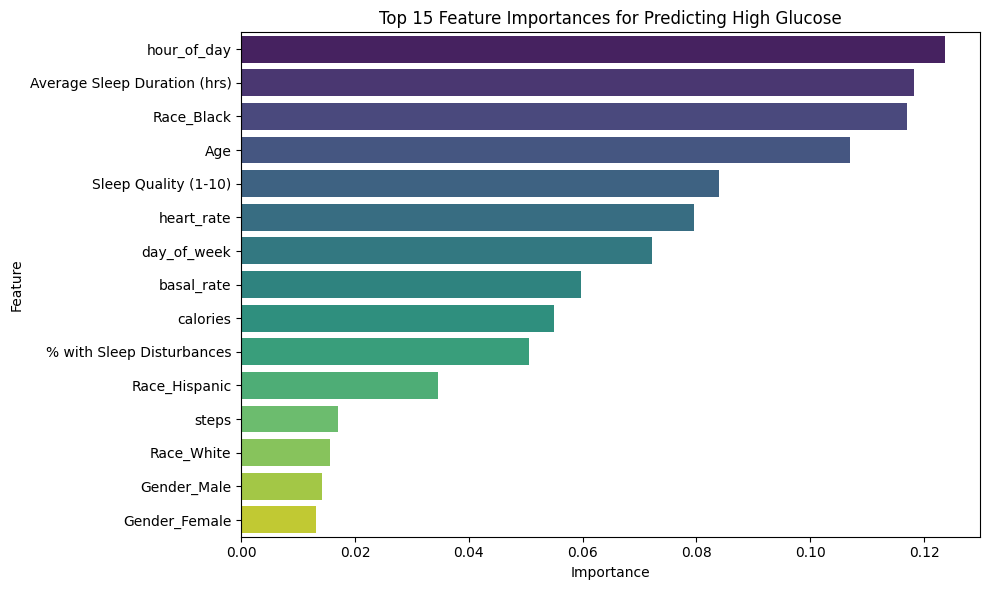

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# -------------------------------
# 1️⃣ Features & target
# -------------------------------
features = ['Age','Gender','Race',
            'Average Sleep Duration (hrs)','Sleep Quality (1-10)','% with Sleep Disturbances',
            'steps','calories','heart_rate','basal_rate',
            'bolus_volume_delivered','carb_input','hour_of_day','day_of_week']
X = diabts_df[features]
y = diabts_df['high_glucose']

numeric_features = ['Age','Average Sleep Duration (hrs)','Sleep Quality (1-10)','% with Sleep Disturbances',
                    'steps','calories','heart_rate','basal_rate','bolus_volume_delivered','carb_input',
                    'hour_of_day','day_of_week']
categorical_features = ['Gender','Race']

# -------------------------------
# 2️⃣ Preprocessing
# -------------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# -------------------------------
# 3️⃣ Train/test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 4️⃣ Train Random Forest
# -------------------------------
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# -------------------------------
# 5️⃣ Feature importance
# -------------------------------
# Categorical feature names after one-hot encoding
onehot_features = rf_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_features)

# Feature importances
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# DataFrame
feat_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
sns.barplot(data=feat_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances for Predicting High Glucose')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Objective of Run Model
Train a single machine learning model using a preprocessing pipeline on the training data.        
Evaluate its performance on the test set by computing key metrics: Accuracy, Precision, Recall, F1 Score, and ROC AUC.          
Visualize the model’s ROC curve to assess its ability to distinguish between classes.          
Return a structured summary of the metrics as a Pandas DataFrame for easy comparison with other models.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

def run_model(model_name, model, X_train, X_test, y_train, y_test, preprocessor):
    """Train one model, plot ROC, and return metrics."""

    pipe = Pipeline([('preprocess', preprocessor), ('classifier', model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else pipe.decision_function(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, color='blue', label=f'{model_name} (AUC={auc:.2f})')
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Results as DataFrame
    results_df = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'ROC AUC': auc
    }])
    return results_df


### Logistic Regression
Train and evaluate to predict the likelihood of high glucose levels.
It applies preprocessing, fits the model, and computes key performance metrics to assess prediction accuracy.

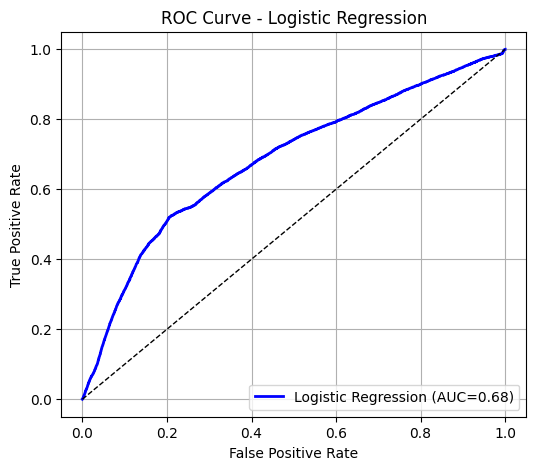

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.78256,0.466931,0.052864,0.094975,0.682895


In [9]:
# Logistic Regression
run_model("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42),
          X_train, X_test, y_train, y_test, preprocessor)

### Logistic Regression results:
Accuracy (78%) looks decent, but it’s misleading because the model barely detects positives (recall ~5%).
Precision (46%) means when it does predict high glucose, almost half the time it’s correct — but since it rarely predicts positives, this has limited use.                              
F1 score (0.09) is very poor, confirming the imbalance between precision and recall.                               
ROC AUC (0.68) shows the model’s ability to separate classes is weak compared to Random Forest (0.73) or XGBoost (0.77).                   
👉 Overall, Logistic Regression is underfitting here — it struggles to capture the complexity of glucose patterns and is not suitable without heavy feature engineering or balancing techniques.

### Random Forest model
Train and evaluate to predict the likelihood of high glucose levels.
It applies preprocessing, fits the model, and computes key performance metrics to assess prediction accuracy.

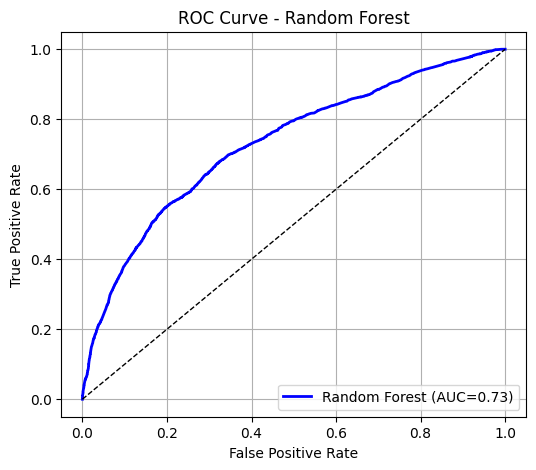

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Random Forest,0.791739,0.633714,0.08304,0.146839,0.729839


In [10]:
# Random Forest
run_model("Random Forest", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
          X_train, X_test, y_train, y_test, preprocessor)

### Random Forest Results:
The accuracy (79%) looks decent, but this is misleading because the recall is very low (8%), meaning the model fails to detect most high-glucose cases.
The precision (64%) shows that when it does predict high glucose, it is often correct, but it rarely makes such predictions.             
The F1 score (0.14) is poor due to the imbalance between precision and recall.         
The ROC AUC (0.73) indicates the model can separate classes better than random, but it’s not leveraging this well in predictions.      

### XGBoost
Train and evaluate to predict the likelihood of high glucose levels.
It applies preprocessing, fits the model, and computes key performance metrics to assess prediction accuracy.

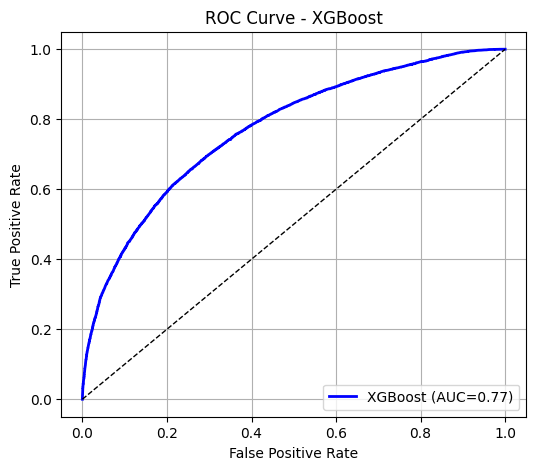

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,XGBoost,0.811988,0.664878,0.259828,0.373641,0.771847


In [11]:

# XGBoost
run_model("XGBoost", XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42),
          X_train, X_test, y_train, y_test, preprocessor)

### XGBoost results:
Accuracy (81%) is strong, but more meaningful is the recall (26%), which is much better than Random Forest (8%), showing XGBoost is better at catching high-glucose cases.                 
Precision (66%) indicates that about two-thirds of predicted high-glucose cases are correct, though it sacrifices some false positives to improve recall.                              
F1 score (0.38) is noticeably higher than Random Forest’s (0.15), showing a better balance between precision and recall.          
ROC AUC (0.77) confirms XGBoost is a stronger classifier with good class separability.                          
👉 Overall, XGBoost provides a better trade-off: it captures more true positives while still maintaining solid precision. You might further boost recall by adjusting the classification threshold (e.g., lowering it from 0.5 to ~0.3).

### KNN
Train and evaluate to predict the likelihood of high glucose levels.
It applies preprocessing, fits the model, and computes key performance metrics to assess prediction accuracy.

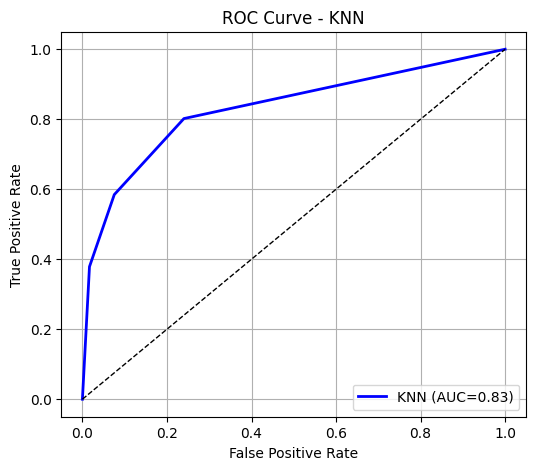

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,KNN,0.851226,0.680942,0.584575,0.629089,0.830217


In [12]:
# KNN
run_model("KNN", KNeighborsClassifier(n_neighbors=3),
          X_train, X_test, y_train, y_test, preprocessor)

### KNN model Results:

Accuracy (85.1%) – The model correctly predicts high glucose status in the majority of cases, indicating decent overall performance.

Precision (68.2%) vs Recall (58.5%) – The model is slightly better at correctly identifying predicted high glucose cases than capturing all actual high glucose cases. Some true positives are missed, so recall is moderate.

F1 Score (62.9%) and ROC AUC (83.0%) – The balanced metric (F1) shows moderate effectiveness considering both precision and recall, while ROC AUC indicates the model has good discriminative ability between high and normal glucose.

### Decision Tree
Train and evaluate to predict the likelihood of high glucose levels.
It applies preprocessing, fits the model, and computes key performance metrics to assess prediction accuracy.

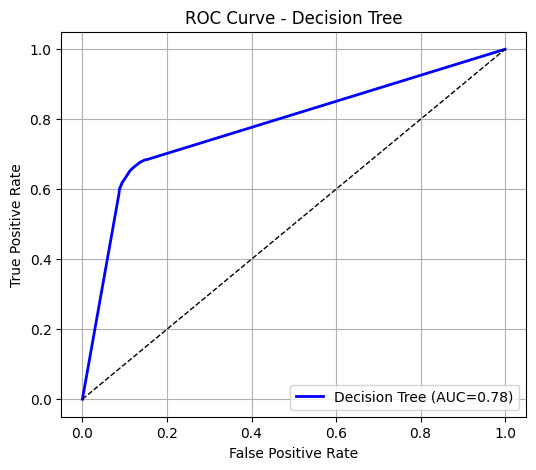

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Decision Tree,0.844115,0.644939,0.617896,0.631128,0.782446


In [13]:
# Decision Tree
run_model("Decision Tree", DecisionTreeClassifier(random_state=42),
          X_train, X_test, y_train, y_test, preprocessor)

Decision Tree model Results:

Accuracy (84.4%) – The model correctly classifies most cases, showing good overall performance.

Precision (64.5%) vs Recall (61.8%) – Precision and recall are fairly balanced, meaning the model identifies high glucose cases reasonably well while keeping false positives moderate.

F1 Score (63.1%) and ROC AUC (78.2%) – The F1 score reflects a balance between precision and recall, while ROC AUC indicates the model has good ability to distinguish high vs normal glucose, though slightly lower than KNN (83.0%).

Summary: Decision Tree provides a balanced approach, but overall discriminative ability is slightly lower than KNN.

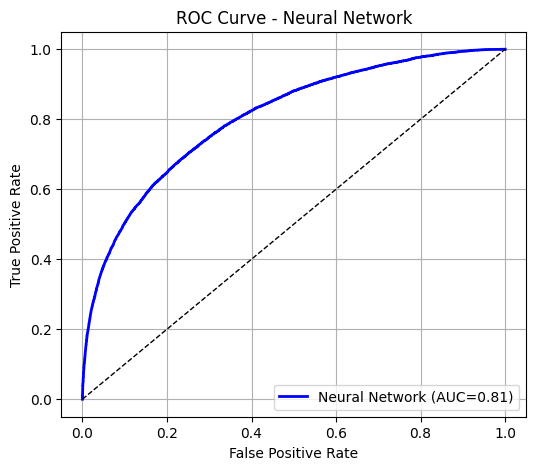

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Neural Network,0.827292,0.68456,0.370498,0.480785,0.806356


In [14]:
# Neural Network (MLP)
run_model("Neural Network", MLPClassifier(max_iter=200, random_state=42),
          X_train, X_test, y_train, y_test, preprocessor)

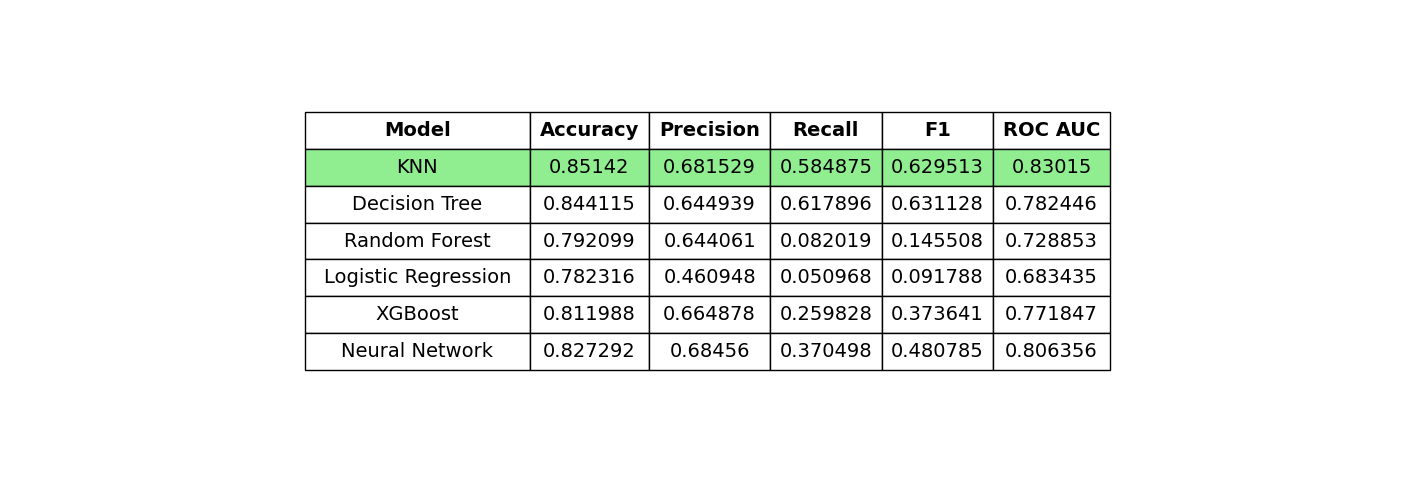

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample results
results = [

    ['Decision Tree', 0.844115, 0.644939, 0.617896, 0.631128, 0.782446],
    ['KNN', 0.85142, 0.681529, 0.584875, 0.629513, 0.83015],
    ['Random Forest', 0.792099, 0.644061, 0.082019, 0.145508, 0.728853],
    ['Logistic Regression',	0.782316,	0.460948,	0.050968,	0.091788,	0.683435],
    ['XGBoost', 0.811988, 0.664878, 0.259828, 0.373641, 0.771847],
    ['Neural Network', 0.827292, 0.68456, 0.370498, 0.480785, 0.806356]
]
columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
df = pd.DataFrame(results, columns=columns)

# Compute Overall metric
numeric_cols = df.columns[1:]
df['Overall'] = df[numeric_cols].mean(axis=1)

# Identify best model
best_idx = df['Overall'].idxmax()

# Move best model to top
df = pd.concat([df.loc[[best_idx]], df.drop(best_idx)]).reset_index(drop=True)

# Define cell colors (only best model green)
cell_colors = []
for i in range(len(df)):
    if i == 0:  # best model row
        color = ['lightgreen'] * len(df.columns[:-1])
    else:
        color = ['white'] * len(df.columns[:-1])
    cell_colors.append(color)

# Plot bigger table
fig, ax = plt.subplots(figsize=(18,6))  # bigger figure
ax.axis('off')
ax.axis('tight')

table = ax.table(
    cellText=df.drop(columns=['Overall']).values,
    colLabels=df.columns[:-1],
    cellColours=cell_colors,
    cellLoc='center',
    loc='center'
)

# Font size & bold headers
table.auto_set_font_size(False)
table.set_fontsize(14)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # header row
        cell.set_text_props(weight='bold', color='black')

# Increase row height
for key, cell in table.get_celld().items():
    cell.set_height(0.08)  # increase row height

table.auto_set_column_width(col=list(range(len(df.columns)-1)))
plt.show()


### Insights:
KNN performed the best overall across Accuracy (85%), F1 (0.63), and ROC AUC (0.83).

Decision Tree had slightly lower Accuracy (84%) but balanced Precision/Recall → also a strong baseline.

Neural Network achieved high Precision (0.68) and decent ROC AUC (0.81) but Recall was moderate (0.37).

Random Forest & Logistic Regression underperformed, especially in Recall (<0.1), indicating poor sensitivity to positives.

XGBoost achieved moderate Accuracy (81%) and Precision (0.66), but Recall remained weak (0.26).

KNN’s advantage: better trade-off between Precision (0.68) and Recall (0.58), making it more reliable for balanced detection.

High Recall is critical in healthcare (to avoid missing true positive cases) → KNN and Decision Tree are preferable over Random Forest / Logistic Regression.

ROC AUC confirms stability: KNN (0.83) outperforms others, showing better overall discrimination.

Trade-off noted: Logistic Regression, despite being interpretable, fails in capturing positive cases (very low Recall).

Recommendation:

Use KNN as the primary predictive model.

Keep Decision Tree as a simple interpretable backup model.

Avoid Random Forest / Logistic Regression due to poor Recall.